##### <font color="C13F38"><strong>This homework is due at midnight on April 4, 2023. </strong></font>

As always: run the cell below to get you started.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import uniform

def reber_patterns():
    # need to actual convert the sequences and then can probably rewrite this code to be more pythonic
    reber_sequences = pd.read_csv('reber_grammar.csv')
    pattern = {}
    pattern['trainingInputs'] = {}
    pattern['testingInputs'] = {}
    rebertrain = reber_sequences['rebertrain'].values
    rebertrain = rebertrain[:-1] # dropping the last NaN
    rebertest = reber_sequences['rebertest'].values
    characters = ['B','T','S','X','V','P','E']
    nrCharacters = len(characters)
    nrTrainingPatterns = len(rebertrain)
    nrTestingPatterns = len(rebertest)

    for i in range(nrTrainingPatterns):
        sequenceLength = len(rebertrain[i])
        pattern['trainingInputs'][i] = np.zeros((nrCharacters,sequenceLength))
        for j in range(sequenceLength):
            pattern['trainingInputs'][i][:,j] = np.array([rebertrain[i][j] == c for c in characters])
    
    for i in range(nrTestingPatterns):
        sequenceLength = len(rebertest[i])
        pattern['testingInputs'][i] = np.zeros((nrCharacters, sequenceLength))
        for j in range(sequenceLength):
            pattern['testingInputs'][i][:, j] = np.array([rebertest[i][j] == c for c in characters])
    
    pattern['trainingStrings'] = rebertrain[:-1]
    pattern['testingStrings'] = rebertest
    pattern['allStrings'] = np.concatenate((rebertrain, rebertest))
    pattern['characters'] = characters

    return pattern

def logistic(x):
    return 1/(1+np.exp(-x))

def activate(model, input, contextActs):
    hiddenActs = logistic(model['i2hWeights']@input + model['c2hWeights']@contextActs)
    outputActs = (np.exp(model['h2oWeights']@hiddenActs))/np.sum((np.exp(model['h2oWeights']@hiddenActs)))
#     print(outputActs)
    return outputActs, hiddenActs

def evaluateModel(model, pattern):
    nrTrainingInputs = len(pattern['trainingInputs'])-1
    trainingAccuracy = np.zeros((nrTrainingInputs,1))

    for p in range(nrTrainingInputs):
        input = pattern['trainingInputs'][p]
        sequenceLength = input.shape[1]
        contextActs = 0.5 * np.ones((model['nrContexts'],1))
        acc = np.zeros((sequenceLength-1,1))

        for i in range(sequenceLength-1):
            outputActs, hiddenActs = activate(model, input[:,i:(i+1)], contextActs)
            contextActs = hiddenActs # recurrence
            
            history = pattern['trainingStrings'][p][:i+1]
            prediction = history + pattern['characters'][np.argmax(outputActs)]
            acc[i] = any([pattern['allStrings'][j].startswith(prediction)
                           for j in range(len(pattern['allStrings']))
                           if len(pattern['allStrings'][j]) >= len(prediction)]) # accuracy is wrong methinks
            trainingAccuracy[p] = np.mean(acc)

    # testing
    nrTestingInputs = len(pattern['testingInputs'])-1
    testingAccuracy = np.zeros((nrTestingInputs,1))
    for p in range(nrTestingInputs):
        input = pattern['testingInputs'][p]
        sequenceLength = input.shape[1]
        contextActs = 0.5 * np.ones((model['nrContexts'],1))
        acc = np.zeros((sequenceLength-1,1))

        for i in range(sequenceLength-1):
            outputActs, hiddenActs = activate(model, input[:,i:(i+1)], contextActs)
            contextActs = hiddenActs
            prediction = np.argmax(outputActs)
            history = pattern['testingStrings'][p][:i+1]
            prediction = history + pattern['characters'][np.argmax(outputActs)]
            acc[i] = any([pattern['allStrings'][j].startswith(prediction)
                            for j in range(len(pattern['allStrings']))
                            if len(pattern['allStrings'][j]) >= len(prediction)])
            testingAccuracy[p] = np.mean(acc)
    return trainingAccuracy, testingAccuracy

# Lab 3.3 - Recurrent neural networks

In this section of the lab, you will be exploring how a recurrent neural network is able to learn a rudimentary form of grammar.

You will notice that you will spend less time coding up the models, and more time investigating its behavior. This is partly because you already spent a bunch of time coding up neural networks, and not so much time investigating how we can use them to investigate cognition. We hope we are giving you a better insight into how psychologists use neural networks to understand the mental processes they study.

However, if you are truly interested in how the model in this lab work, we encourage you to dive into the code. You will see that the code is written _very much_ in the style of all the models you have seen, so hopefully that will help in making them a bit more interpretable.

You can earn 25 points on this lab.

_Credits_
This first section of the assignment is a modification of the exercises on the Reber grammar given in the original PDP handbook by Jay McClelland, as well as the assignments based on this chapter by Todd Gureckis and Brenden Lake.

This lab draws on work from the following publications:

Cleeremans, A. and McClelland, J. L. (1991). Learning the structure of event sequences. Journal of Experimental Psychology General, 120, 235–253.

Servan-Schreiber, D., Cleeremans, A., and McClelland, J. L. (1991). Graded state machines: The representation of temporal contingencies in simple recurrent networks. Machine Learning, 7, 161–193.

# 1. Recurrent neural networks and the Reber grammar
As we discussed in class, it is not trivial to design a neural network that is able to learn the temporal sequence of information. Of course, one could teach a simple feedforward network a list of input-output pairs in order, where the desired output of the previous pair is the input of the next one. However, there would be nothing inherently temporal about the learned associations. More importantly, the network would not be able to represent anything about the temporal context. In other words, it would not know what happened before the current input. In contrast, humans continuously rely on this information to make predictions.

To deal with this limitation of feedforward neural networks, Jeffrey Elman designed the recurrent neural network in 1990:

![rnn](rnn_3-3-1.png)

A recurrent neural network looks a lot like a ‘regular’ neural network, except that its task is to use the current input to predict what the next input would be. In this way, it is trying to learn something about the _structure_ of the information that it faces. The network also differs from the ones we have studied before in its structure. As you surely noticed, the network has an extra set of ‘context’ nodes. These context nodes are essentially an extension of the input layer, but they have a special property: their activation is a _copy_ of the activity of the hidden layer on the previous time step.

In essence, this induces a rudimentary form of memory into our model. It now not only knows what happens _right now_, but also what happened on the previous time step. This simple addition to the model has two implications. First, it makes backpropagation much more elaborate. We saw this in class, but luckily you will not have to worry about coding this up. Second, it allows the model to make predictions about what happens next based on the current information and the context in which this happened.

To see why this is an important extension of neural networks, today we are going to expose a recurrent neural network to the “Reber grammar”. This is an artificial grammar that has a bunch of desirable properties that let us test whether the neural network will be able to use its temporal context to make informed predictions about what will happen next.

# 1.1 The Reber grammar

The rules of the artificial Reber grammar are best described in the flow chart below:

![reber-grammar](reber-grammar.png)

The grammar spells out a set of set of allowable or grammatical sequences of symbols. The flowchart above lets you construct these sequences! The grammar automatically starts with the left most arrow. If you are at a node, you follow an arrow from the current node to the next. Each arrow is associated with a letter, and when you transition through that arrow, you add the associated letter to the sequence. Each sequence you can get by going through this sequence is considered grammatical. Note that every sequence begins with B (for beginning) and ends with E (for end).

So, for example, after our first transition, we can go down past P, then to the right past V, then up past another V, and then past E to the finish, so we have constructed the sequence ‘BPVVE’.

There are many other sequences! For example, the self-connecting nodes will allow you to insert the infinite series of T and S into the sequences. Also, there is a loop in the flowchart that lets you insert infinite series of letters that do not immediately repeat. So, for example, ‘BTXSSSSSSSSSSSSSE’ and ‘BPTVPXVPXVPXVPXTVVE’ are both grammatical sequences. If a sequence cannot be constructed using this flowchart, it is considered not grammatical.



<font color="508C46"><strong>Question 1 (2 points)</strong><br>
Let's make sure you understand the Reber grammar. Which of the following sequences are grammatical?
1. BPTVVE
2. BTSSSXXXVVE
3. BPTTVPSE
4. BTSSSXVPSE
5. BTXXVVPXVVE
<font> 


.. double click this to type your response.

1 and 3


Now, the neat thing about the Reber grammar is that in order to learn it, that is in order to be able to predict which character comes next, you cannot not pay attention to just the previous character. In fact, you need to incorporate the characters that occurred before that as well. To see this, you are going to pretend to be a ‘zero-order’, ‘first-order’, and ‘second-order’ memory predictor. In other words, you will have to make predictions about the next letter, based on different memory sizes. The zero-order memory predictor has no memory, not even knowing the current input. The first-order memory predictor can only remember one letter back. And, perhaps, unsurprisingly, the second-order memory predictor remembers two letters back.

<font color="508C46"><strong>Question 2 (1 point)</strong><br>
What is the zero-order structure of the grammar? In other words, if you did not even know the most recent letter, what can you predict about the output? You can find the answer to this question by figuring out the relative frequency of the various outputs. Of course, B is never a possible output (because each sequence starts automatically with that letter), but all other letters can be outputs. So, the zero-order structure is the relative frequency of each letter as an output.
<font> 


.. double click this to type your response

Frequency of every letter is 2 except for E which has a frequency of 1

<font color="508C46"><strong>Question 3 (2 point)</strong><br>
**<u>What is the first-order structure of the grammar? In other words, for each the letters in this task (‘B’, ‘T’, ‘S’, ‘X’, ‘P’, ‘V’), what are the possible successors (following letters) given just a first-order memory?</u>** Hint: ‘B’ has two possible successors, and there are three letters with the same set of successors.
<font> 


.. double click this to type your response

B has two successors T and P
T has 4 succhessors, S, X, T, and V
S has 3 successors, S, X, and E
X has 4 successors, S, X, T, and V
P has 4 successors, S, X, T and V
V has 3 successors, V, E, P

<font color="508C46"><strong>Question 4 (2 point)</strong><br>
Finally, let’s explore the second-order structure of some of the grammar (we won’t go through the full possibilities because this will get too laborious). In the table below, we have given all possible two-order sequences that end in T or X (feel free to check our work). **<u>What are the possible successors?</u>**
<font> 

Double click to fill out the following table:

| Sequence | Successors |
| ---------| ---------- |
| BT |S, X |
| TT |T,V |
| XT |T,V | 
| PT | T,V| 
| TX | S,X| 
| SX |S,X | 
| XX | T,V| 
| PX | T,V| 

<font color="508C46"><strong>Question 5 (4 points)</strong><br>
**<u>Based on these questions, why is it useful to have a second-order memory in this task? Do you think it would be better to have third-order memory?</u>**
<font> 


.. double click this to type your response.

The higher order you go, the fewer output possibilities there are. This reduces error in a model. A third order memory, however, might risk not capturing the grammar fully

# 2. Inspecting the recurrent neural network, and its input
In 1991, Cleeremans and McClelland performed a study in which six participants learned the structure of a, slightly different, Reber grammar. Specifically, they performed 20 sessions of the task. In each of these, they responded to 3100 stimuli that followed this algorithm (The participants were instructed that the task was about motor learning, and so they pressed buttons according to six dots that appeared on a horizontal line on the screen. Each dot corresponded to one letter, but participants never saw the actual letters). So, people saw 62000 (!) trials of the Reber grammar. To test whether people were making predictions about the following letter, on 15% of the trials, a different, non-grammatical letter was substituted. Interestingly, Cleeremans and McClelland found that early in the experiment participants’ behavior largely followed the first-order structure that you reported in _Question 3_. They weren’t _surprised_ when a non-grammatical letter occurred, as long as that letter occurred in the first-order structure predicted by the previous letter. So, if the previous letter was ‘T’, their behavior suggested that people thought there were four possible next letters, even if there were only two (see Question 4)! Later on, however, participants became much more sensitive to the context in which the letters occurred, and so their behavior started following the second-order structure of the grammar much more.

Here, we are going to use a recurrent neural network, to see if we can model this development in learning. The recurrent network looks like this:

![rnn-3-3-2](rnn_3-3-2.png)


It has 7 input neurons and 7 output neurons, one for each letter. On each ‘trial’ the network will be presented with a letter. Each of the input units will have activity 0, except for the current letter, which will be 1. This form coding is known as ‘one-hot’ encoding, because only one neuron is on or ‘hot’. The output that needs to be learned is simply the next letter, or the one-hot encoded version of that letter. To make this explicit, if the first letter in a sequence is B, and the next one is T (is this grammatical?), then the input is [1 0 0 0 0 0 0], and the correct output would be [0 1 0 0 0 0 0].


In order to allow the network to encode the current ‘context’, on each step it receives additional input to the hidden layer from the context units (each have 8 units in our model). These units are special, because their activity is copied from the hidden units on the previous step (except for the first step, where they are all 0.5). This way, we are allowing the model to respond differently to the same letter when it occurs in different positions in the grammar.

The context units represent what happened on the previous trial. So, they are a form of memory, allowing the network to connect consecutive inputs and (hopefully) learn the structure of the Reber grammar.

Here are some technical specs about the types of activation functions. The neurons in the hidden layer use a logistic transformation over the net input, so that each neuron’s output is scaled between 0 and 1. The output layer, however, performs a _softmax_ activation function, so all activity across all neurons sums to 1. This is useful here, because we are trying to figure out which letter the network predicts will come next. This best takes form as a probability distribution, and the softmax gives us exactly that. You won’t see this in the lab, but using a softmax activation function actually makes backpropagation a bit easier!

# 2.1 Inspecting the input and output patterns

Let’s first inspect the patterns that we will use to train the neural network. You may notice that there is a .csv file in the data folder called reber_grammer.csv. If you open it, you will see that this file contains two columns, `rebertrain` and `rebertest`. If you inspect them, you will see that both these cell arrays contain sequences of the Reber grammar. Together, these represent all 43 possible sequences with maximum length 10, split as equally as possible between the two columns. There are two columns, because we will train the model on one set of sequences, and then test its performance on another set of sequences.

<font color="508C46"><strong>Question 6 (2 points)</strong><br>
**<u>Why is it a good idea to train and test your model on different data?</u>**
<font> 


.. double click this to type your response.

To make sure it is applicable to the cognitive process as a whole rather than overfitting to a specific dataset 

Of course, the sequences in these files are not in the correct format. The cell arrays contain strings, and not one-hot encoded vectors, so the recurrent neural network wouldn’t be able to handle it.
This is where the function `reber_patterns` comes in handy. We wrote this for you. Let’s give it a try! Try the code below and look at the variable `pattern`.


In [6]:
pattern = reber_patterns()
pattern

{'trainingInputs': {0: array([[1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1.]]),
  1: array([[1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1.]]),
  2: array([[1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 1., 0., 1., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1.]]),
  3: array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0.,

The most important fields of this variable are `'trainingInputs'` and `'testingInputs'`. These are dictionaries of 21 and 22 keys respectively. Each value of these dictionaries again contains a sequence of letters, but now in a matrix and in one-hot encoded form. Let’s see what that looks like, by inspecting the content of the second training input:

In [7]:
pattern['trainingInputs'][0]

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

This input has 7 rows and 5 columns. If you inspect other trainingInputs, you will notice that all of them have 7 rows as well, but that the number of columns differs between them. So, the rows represent which letter occurs, and the columns indicated in which temporal sequence it occurs. Using the field characters of the pattern variable, we can now decode that this sequence corresponds to BTXSE. To see this, consider which rows have the one in them across columns, and then check how those indices correspond the letters in characters.

Note that in the exercises for Lab 3.1, the patterns always had a desired output for each input. Why are there only inputs now?

# 2.2 A bird's eye view of the model

Take a look at `initModel`. As in Lab 3.1 exercises, this function will initialize the model. You’ll notice that the model 7 input neurons, 7 output neurons, 8 hidden neurons and 8 context neurons. There are connections between the hidden layer and the output layer, the input layer and the hidden layer, and the context layer and the hidden layer. All these connections will be modified over the course of learning. Note that initModel does not set the connection weights from the hidden layer to the context layer (why?).





In [8]:
def initModel():
    model = {}
    model['nrInputs'] = 7
    model['nrHiddens'] = 8
    model['nrContexts'] = model['nrHiddens']
    model['nrOutputs'] = 7

    model['h2oWeights'] = np.random.uniform(-0.35, 0.35, (model['nrOutputs'], model['nrHiddens']))
    model['i2hWeights'] = np.random.uniform(-0.25, 0.25, (model['nrHiddens'], model['nrInputs']))
    model['c2hWeights'] = np.random.uniform(-0.25, 0.25, (model['nrHiddens'], model['nrContexts']))
        
    model['learningRate'] = 0.01
    return model

# 2.3 Backpropagation through time
We have established the structure of the network and what each input and corresponding output is going to be, so it seems like we are ready to train the model.

How we are going to do this? The answer is very simple, and kind of complicated at the same time. The simple answer is that we are again going to use back propagation. So, after each sequence is presented, we are going to calculate the error of the network for each input, and then we are going to use this error to update the connection weights of the model (of course taking into account how active the projecting neurons were).

This all sounds very much like what we have been doing, so where does it get complicated? Well, as you may remember from class, many steps of activity in a recurrent neural network can be viewed as single network that gets ‘folded’ out over time. Here is a diagram below that demonstrates this, with $x_t$, $h_t$, and $y_t$, the activity of the input, hidden, and output layer on trial t. And $U$, $V$, and $W$ the connection weights between the different layers.

![rnn_3-3-3](rnn_3-3-3.png)

Viewed this way, it’s easy to see that because the hidden layer is recurrent, the activity of the input neurons on any previous step will affect the output on the current step. The same can be said for the activity of the hidden neurons on any previous step. So, in order to update the connections from the hidden layer to the output layer based on the error on $t = 4$, we need to take _propagate this error back through time_, so that it can adjust the connection weights appropriately for each of the inputs. Now, we need to do this for step 3, as well, and so on.

As you saw in class, this gets messy. And therefore, I will spare you the details. That being said, let’s have a quick look at `trainModel`, just so that you can develop an intuition for how it works.

In [9]:
# trainModel code
def trainModel(nrEpochs):
    model = initModel()
    pattern = reber_patterns()
    nrTrainingPatterns = len(pattern['trainingInputs'])

    results = {}
    results['trainingAccuracy'] = []
    results['testingAccuracy'] = []
    results['meanLL'] = np.zeros(nrEpochs)
    results['model'] = []
    
    for epoch in range(nrEpochs):
        # randomize the presentation
        order = np.random.permutation(nrTrainingPatterns)
        # initialize the loss function
        loss = []
        for i in range(nrTrainingPatterns):
            
            input = pattern['trainingInputs'][order[i]]
            sequenceLength = input.shape[1]
            
            currentContextActs = 0.5 * np.ones((model['nrContexts'],1))
            outputActs = np.zeros((model['nrOutputs'],sequenceLength-1))
            hiddenActs = np.zeros((model['nrHiddens'],sequenceLength-1))
            inputActs = np.zeros((model['nrInputs'],sequenceLength-1))
            contextActs = hiddenActs.copy()
            gradient = outputActs.copy()
            
            # here we activate the model, and predict the next letter
            for j in range(sequenceLength-1): # don't predict last pattern
                outputActs[:,j:(j+1)] , hiddenActs[:,j:(j+1)] = activate(model, input[:,j:(j+1)], currentContextActs)
                contextActs[:,j:(j+1)] = currentContextActs
                inputActs[:,j] = input[:,j]
            
                error_deriv = outputActs[:,j] - input[:,j+1]
                gradient[:,j] = error_deriv
                
                # copy hidden activations to context
                currentContextActs = hiddenActs[:,j:(j+1)]
                
                # calculate and store loss
                loss_update = -np.sum(input[:,j+1] * np.log(outputActs[:,j]))
                loss.append(loss_update)
                        
            delta_h2o = np.zeros((model['h2oWeights'].shape))
            delta_i2h = np.zeros((model['i2hWeights'].shape))
            delta_c2h = np.zeros((model['c2hWeights'].shape))
            
            # this is where backpropagation through time happens
            for j in range(sequenceLength-1)[::-1]: # reversed
                            
                delta_h2o += gradient[:,j:(j+1)]*hiddenActs[:,j]
                gradient_over_time = (model['h2oWeights'].T @ gradient[:,j:(j+1)])*hiddenActs[:,j:(j+1)] * (1 - hiddenActs[:,j:(j+1)])
                
                for k in range(j+1)[::-1]: # backprop through time
                    
                    delta_i2h += gradient_over_time*inputActs[:,k]
                    delta_c2h += gradient_over_time*contextActs[:,k]

                    gradient_over_time = (model['c2hWeights'].T @ gradient_over_time) * contextActs[:,k:(k+1)] * (1 - contextActs[:,k:(k+1)])
                    
            model['h2oWeights'] -= model['learningRate'] * delta_h2o
            model['i2hWeights'] -= model['learningRate'] * delta_i2h
            model['c2hWeights'] -= model['learningRate'] * delta_c2h
                         
        results['meanLL'][epoch] = np.nanmean(loss)
        
        if epoch % 20 == 0:
            trainingAccuracy, testingAccuracy = evaluateModel(model, pattern)
            results['trainingAccuracy'].append(np.mean(trainingAccuracy))
            results['testingAccuracy'].append(np.mean(testingAccuracy))
            
    return model,results

A lot of this will look familiar, the script loads a model and the patterns, and then creates some vectors to store some evaluation results. Next, it trains the model for nrEpochs, which is an input parameter that we are going to mess with in a bit.

On each epoch it goes through all training inputs (sequences) in random order. After picking a sequence, it first presents each letter, calculating the activation, the error, and the negative loglikelihood on each step.

Then, it uses a double `for` loop to update the model, starting with the error on the very last time step, and back propagating that error to all previous time steps in the sequence. After this it will do the same for the second-to-last time step, continuing to backpropagate its error to all previous timesteps, and repeating the process until it has reached the first time step.

Throughout this process, all the delta terms (changes in network weights) get added, and then they get applied, at the same time, to the connection weights.

Finally, every 20 trials, `trainModel` runs a simple evaluation of how good the model is at predicting a valid successor for each time step of each sequence in the training and testing patterns (lines 76-82).

If you want to understand the code, I’d be happy to walk you through it in more detail. However, this is not strictly necessary. As long as you have an intuition for how backpropagation through time works, and how it is different and the same as ‘regular’ backpropagation, you are ready to start training the model.

## 2.3.1 Evaluation of model performance
What is a good metric for evaluating model performance? As you know, simply looking at whether the model’s prediction follows the first-order structure is not enough. That way, we can a model could predict that BTS will be followed by E, and we would count it as correct.

The function `evaluateModel` takes a better approach. It runs through a sequence and records the model’s prediction on each timestep (i.e., the neuron with the highest activation). For each step, it then counts this prediction as correct if it follows the grammar (Specifically, it runs through all the testing and training strings (because those are all possible sequences of length 10), and it figures out whether any of them start with the current history of letters followed by the predicted letter.).

As we said above, this function gets called every 20 trials during `trainModel`, so we get a good insight into how our model’s performance is developing over time.

# 3 Training and evaluating the model
Let’s train the model! When using `trainModel`, you do not have to initialize the model or provide the training patterns, the function will do this automatically. The only thing you have to do is to provide a number of _epochs_. Let’s start with 500 epochs.

In order to answer the next few questions, you need to train a model using `trainModel` for 500 epochs, and make sure to also store the secondary output `results`. Note that we are training the model on 500 × 21 = 10500 sequences.

<font color="508C46"><strong>Question 7 (2 points)</strong><br>
Make a plot that depicts how the model’s accuracy on both the testing and the training sequences develops over time. **<u>Which accuracy seems to be higher? Why? Show the plot.</u>**
<font> 

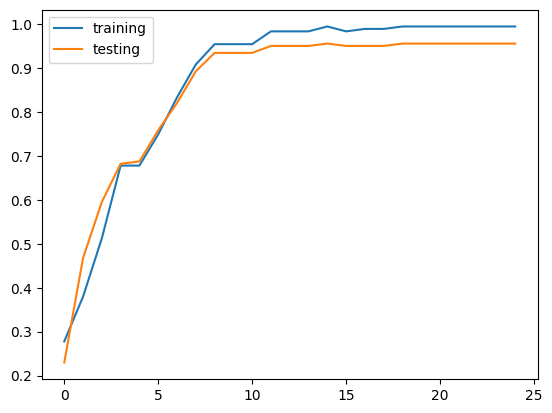

In [10]:
# your code here
model, results =trainModel(500)
training_accuracy= results['trainingAccuracy']
testing_accuracy= results['testingAccuracy']
plt.plot(training_accuracy, label="training")
plt.plot(testing_accuracy, label="testing")
plt.legend()


.. double click this to type your response.

The training sequences has a higher level of accuracy than the testing sequence because that is what the model was traind on and there is thus some overfitting occuring. The testing still shows a pretty good learning/ accuracy though

# 1.4 Visualizing the model's predictions
Looking at performance scores gives us a good indication that the model is learning, but it doesn’t tell us how well it is doing. In order get a sense for this, we wrote a function called `showActivations`. This function takes as its input a model and a sequence of letters, and then it prints the predicted next letters (the activation in the output layer) for each step of the sequence.

For example, here I run the function for a sequence with just the letter ‘B’:

```python
showActivations(model, 'B')
```

You can see that the model splits its prediction between T (56%) and P (42%). It is important to realize that the network does not always split its activity evenly between valid successors, because the training patterns are not precisely balanced in this way.

Run the function `showActivations` using the trained `model`, and the sequence 'BTSXSE' as the input. Note that it makes reasonable predictions now, splitting its probability between two possible (valid) successors at each step.



In [11]:
def showActivations(model,sequence):
    characters = ['B','T','S','X','V','P','E']
    nrCharacters = len(characters)
    sequenceLength = len(sequence)
    input = np.zeros((nrCharacters,sequenceLength))
    for i in range(sequenceLength):
        input[:,i] = [sequence[i] == c for c in characters]
    contextActs = 0.5 * np.ones((model['nrContexts'],1))

    for j in range(sequenceLength):
        if sequence[j] != 'E':
            outputActs, hiddenActs = activate(model, input[:,j:(j+1)], contextActs)
            contextActs = hiddenActs
            print('Input: ', sequence[j], 'Output: ', characters[np.argmax(outputActs)])
            for i in range(len(outputActs)):
                print(characters[i], ': ', np.round(outputActs[i],2))

In [12]:
# your code here
showActivations(model, ['B','T','S','X','S','E'])

Input:  B Output:  T
B :  [0.]
T :  [0.57]
S :  [0.]
X :  [0.]
V :  [0.01]
P :  [0.41]
E :  [0.]
Input:  T Output:  S
B :  [0.]
T :  [0.]
S :  [0.58]
X :  [0.4]
V :  [0.]
P :  [0.]
E :  [0.01]
Input:  S Output:  X
B :  [0.]
T :  [0.]
S :  [0.45]
X :  [0.52]
V :  [0.]
P :  [0.]
E :  [0.03]
Input:  X Output:  X
B :  [0.]
T :  [0.]
S :  [0.24]
X :  [0.76]
V :  [0.]
P :  [0.]
E :  [0.]
Input:  S Output:  E
B :  [0.]
T :  [0.]
S :  [0.01]
X :  [0.01]
V :  [0.01]
P :  [0.01]
E :  [0.96]



# 1.5 Characterizing the development of learning over time
Now we return to our characterization of how learning this artificial grammar unfolds in humans. Recall that Cleeremans and McClelland had participants view this grammar for many trials. They were able to measure _how surprised_ people were by agrammatical substitutes. This in turn, let them figure out how much context people were using to make predictions. They found that early on during learning, people’s behavior suggested that they were making first-order predictions, whereas later on, as they mastered the grammar, their predictions incorporated a richer context (they took into account what happened a few trials back).

Let’s see whether we can get something similar out of our networks!


<font color="508C46"><strong>Question 8 (10 points)</strong><br>
Train three networks, one with only 5 epochs, one with 50 epochs, and another with 500 epochs of training. For each, use showEvaluations on at least two sequences from the <u>_test set_</u>. **<u>What has the network learned?</u>** You should motivate your answer with examples. Think about what kind of order in memory the model’s behavior is best described as. (How can you test what the memory order of the model is? Think about which testing sequences you want to use, and how they are able to inform you about what the model knows.)
<font> 

In [16]:
# your code here
model, results =trainModel(5)
print(showActivations(model,['B','P','T','T','T','V','V','E']))
print(showActivations(model,['B','P','V','P','X','T','V','E']))

Input:  B Output:  V
B :  [0.05]
T :  [0.16]
S :  [0.15]
X :  [0.16]
V :  [0.21]
P :  [0.15]
E :  [0.12]
Input:  P Output:  V
B :  [0.04]
T :  [0.16]
S :  [0.15]
X :  [0.17]
V :  [0.22]
P :  [0.14]
E :  [0.12]
Input:  T Output:  V
B :  [0.05]
T :  [0.16]
S :  [0.15]
X :  [0.16]
V :  [0.21]
P :  [0.14]
E :  [0.13]
Input:  T Output:  V
B :  [0.05]
T :  [0.16]
S :  [0.15]
X :  [0.16]
V :  [0.21]
P :  [0.14]
E :  [0.13]
Input:  T Output:  V
B :  [0.05]
T :  [0.16]
S :  [0.15]
X :  [0.16]
V :  [0.21]
P :  [0.14]
E :  [0.13]
Input:  V Output:  V
B :  [0.05]
T :  [0.16]
S :  [0.15]
X :  [0.16]
V :  [0.22]
P :  [0.15]
E :  [0.12]
Input:  V Output:  V
B :  [0.05]
T :  [0.16]
S :  [0.15]
X :  [0.16]
V :  [0.22]
P :  [0.15]
E :  [0.12]
None
Input:  B Output:  V
B :  [0.05]
T :  [0.16]
S :  [0.15]
X :  [0.16]
V :  [0.21]
P :  [0.15]
E :  [0.12]
Input:  P Output:  V
B :  [0.04]
T :  [0.16]
S :  [0.15]
X :  [0.17]
V :  [0.22]
P :  [0.14]
E :  [0.12]
Input:  V Output:  V
B :  [0.05]
T :  [0.16]
S :  

... double click this to type your response.

Clearly, the model has not learned anything yet because the output is always V

In [18]:
# your code here
model, results =trainModel(50)
print(showActivations(model,['B','P','T','T','T','V','V','E']))
print(showActivations(model,['B','P','V','P','X','T','V','E']))

Input:  B Output:  T
B :  [0.]
T :  [0.23]
S :  [0.13]
X :  [0.13]
V :  [0.21]
P :  [0.18]
E :  [0.12]
Input:  P Output:  V
B :  [0.]
T :  [0.19]
S :  [0.19]
X :  [0.21]
V :  [0.23]
P :  [0.09]
E :  [0.08]
Input:  T Output:  V
B :  [0.]
T :  [0.19]
S :  [0.17]
X :  [0.2]
V :  [0.25]
P :  [0.1]
E :  [0.08]
Input:  T Output:  V
B :  [0.]
T :  [0.19]
S :  [0.17]
X :  [0.2]
V :  [0.25]
P :  [0.1]
E :  [0.08]
Input:  T Output:  V
B :  [0.]
T :  [0.19]
S :  [0.17]
X :  [0.2]
V :  [0.25]
P :  [0.1]
E :  [0.08]
Input:  V Output:  P
B :  [0.]
T :  [0.13]
S :  [0.1]
X :  [0.11]
V :  [0.22]
P :  [0.25]
E :  [0.19]
Input:  V Output:  P
B :  [0.01]
T :  [0.12]
S :  [0.11]
X :  [0.12]
V :  [0.2]
P :  [0.24]
E :  [0.21]
None
Input:  B Output:  T
B :  [0.]
T :  [0.23]
S :  [0.13]
X :  [0.13]
V :  [0.21]
P :  [0.18]
E :  [0.12]
Input:  P Output:  V
B :  [0.]
T :  [0.19]
S :  [0.19]
X :  [0.21]
V :  [0.23]
P :  [0.09]
E :  [0.08]
Input:  V Output:  P
B :  [0.]
T :  [0.13]
S :  [0.1]
X :  [0.11]
V :  [0.

... you can also add text here

The model is slightly better here. For instance, V outputs P rather than V, in accordance to the rules

In [20]:
# your code here
model, results =trainModel(500)
print(showActivations(model,['B','P','T','T','T','V','V','E']))
print(showActivations(model,['B','P','V','P','X','T','V','E']))

Input:  B Output:  T
B :  [0.]
T :  [0.57]
S :  [0.]
X :  [0.]
V :  [0.01]
P :  [0.42]
E :  [0.]
Input:  P Output:  T
B :  [0.]
T :  [0.59]
S :  [0.01]
X :  [0.]
V :  [0.38]
P :  [0.01]
E :  [0.]
Input:  T Output:  V
B :  [0.]
T :  [0.33]
S :  [0.02]
X :  [0.01]
V :  [0.64]
P :  [0.01]
E :  [0.]
Input:  T Output:  V
B :  [0.]
T :  [0.26]
S :  [0.01]
X :  [0.]
V :  [0.73]
P :  [0.]
E :  [0.]
Input:  T Output:  V
B :  [0.]
T :  [0.2]
S :  [0.]
X :  [0.]
V :  [0.8]
P :  [0.]
E :  [0.]
Input:  V Output:  P
B :  [0.]
T :  [0.01]
S :  [0.]
X :  [0.]
V :  [0.42]
P :  [0.56]
E :  [0.01]
Input:  V Output:  E
B :  [0.]
T :  [0.]
S :  [0.01]
X :  [0.]
V :  [0.]
P :  [0.01]
E :  [0.98]
None
Input:  B Output:  T
B :  [0.]
T :  [0.57]
S :  [0.]
X :  [0.]
V :  [0.01]
P :  [0.42]
E :  [0.]
Input:  P Output:  T
B :  [0.]
T :  [0.59]
S :  [0.01]
X :  [0.]
V :  [0.38]
P :  [0.01]
E :  [0.]
Input:  V Output:  P
B :  [0.]
T :  [0.01]
S :  [0.]
X :  [0.]
V :  [0.24]
P :  [0.7]
E :  [0.04]
Input:  P Output: 

... and here!

The model has learned it pretty well as shown in confidence levels